<font size=5> Demo 说明 </font>
    
1. <font size=4> ***本文档展示了如何用 `utils/` 中的函数进行建模。使用前请按照repo里面的 `/modeling/requirements.txt`安装相关包。安装方法请见 `/modeling/README.md`  *** </font>
2. <font size=4> ***本文档所展示的代码仅为无卡建模实例，其他建模过程还需根据具体情况做相应的调整。***</font> <font size=6 color=red> ***请勿直接照搬!*** </font>

# Import packages/modules

In [1]:
%matplotlib inline

import os
import sys
import json
import logging
import warnings
warnings.filterwarnings('ignore')

# 更改为自己的路径,或者直接在环境变量中添加
# sys.path.append('/Users/pintec/Desktop/genie/')

import pandas as pd
import numpy as np
from jinja2 import Template

#python3种reload函数不能直接使用
from imp import reload

from utils3.data_io_utils import *
import utils3.misc_utils as mu
import utils3.summary_statistics as ss
import utils3.metrics as mt
import utils3.feature_selection as fs
import utils3.plotting as pl

# 设置数据路径

In [3]:
DATA_PATH = '/Users/ying.xie/Documents/yings_file/Seafile/分析文件/modeling/个贷/XJD_WK_A_V1/03_data'
RESULT_PATH = '/Users/ying.xie/Documents/yings_file/Seafile/分析文件/modeling/个贷/XJD_WK_A_V1/04_result'

# 整理数据字典

In [4]:
var_dict = pd.read_excel(DATA_PATH+'/变量字典.xlsx')

# 读取数据
<font size=4> 数据准备过程中最好将所有的数据</font> <font size=4 color=red>一次取全</font> 

## 读取建模数据

In [5]:
model_data = pd.read_csv(os.path.join(DATA_PATH,'all_data_for_test.csv'),encoding='GBK')

## 读取样本外数据
<font size=4> 无卡建模不存在样本外数据，这里将选择其他数据代替样本外数据</font> 

In [6]:
out_sample_data = load_data_from_python2_pickle(DATA_PATH,'all_data.pkl')[:2000]
out_sample_data.count(0).to_frame('N_variables').head(1)

,N_variables
applicationid,2000


## 拒绝样本

In [7]:
rejected_data = load_data_from_python2_pickle(DATA_PATH,'reject_data_T.pkl')
rejected_data.count(0).to_frame('reject_variables').head(1)

,reject_variables
var_code,
apply_id,28905


In [88]:
# 随机选择10000个拒绝样本
index_col = list(rejected_data.index)
np.random.shuffle(index_col)
reject_data_4test = rejected_data[rejected_data.index.isin(index_col[:10000])]
reject_data_4test.reset_index(drop=True,inplace=True)

## 近一个月样本

In [9]:
recent_1m_data = load_data_from_pickle(DATA_PATH,'recent_1m_data.pkl')

# 整理X,y数据
** <font size=4>重要：将数据的index设置为 applyid或者unique identifier </font>**

In [10]:
X = model_data[var_dict[u'指标英文']]
X.index = model_data.applicationid
model_data['y'] = np.where(model_data.his_max_overdue_days>30,1,0)
y = model_data['y']
y.index = model_data.applicationid

# 填充缺失值
处理缺失值的时候，发现-9999999是原始数据中已经标注的缺失值。

In [11]:
X = mu.process_missing(X, var_dict,known_missing={-9999999: -8887})

Warnings: downflag variable is not in downflagmap provided for 芝麻IVS
Warnings: downflag variable is not in downflagmap provided for 算话
Warnings: downflag variable is not in downflagmap provided for 蜜罐
Warnings: downflag variable is not in downflagmap provided for 同盾线上
Warnings: downflag variable is not in downflagmap provided for 芝麻DAS
Warnings: downflag variable is not in downflagmap provided for 资信
Warnings: downflag variable is not in downflagmap provided for 未分组
Warnings: downflag variable is not in downflagmap provided for 申请信息
Warnings: downflag variable is not in downflagmap provided for 读秒个贷业务数据
Warnings: downflag variable is not in downflagmap provided for 话单
Warnings: downflag variable is not in downflagmap provided for 积木内部逾期
Warnings: downflag variable is not in downflagmap provided for 聚信力
Warnings: downflag variable is not in downflagmap provided for 本地黑名单详情


# 转换数据类型
至此，数据预处理已经完成，直接存成pickle可保留处理过的数据类型。 <font size=4> 保存前确保index为applyid或其他uniqe identifier </font>

In [12]:
X = mu.convert_right_data_type(X, var_dict,quick_mode=False)[0]

In [13]:
y = pd.DataFrame(y)

In [15]:
# 添加申请月份字段，为后续数据统计做准备
all_data_with_y = pd.merge(X,y,left_index=True,right_index=True)
model_data['appmon'] = model_data.applicationdate.apply(lambda x : x[:7])
appmon = model_data.appmon
appmon = pd.DataFrame(appmon)
appmon.index=model_data.applicationid
all_data_with_y_appmon = pd.merge(all_data_with_y,appmon,left_index=True,right_index=True)

<font size=4>pickle 默认保存为python3格式，如果想保存成python2格式可选择相应方法</font>

In [16]:
save_data_to_pickle(all_data_with_y_appmon, DATA_PATH, 'all_with_y_month.pkl')
# 保存为python2格式
# save_data_to_python2_pickle(all_data_with_y_appmon, DATA_PATH, 'all_with_y_month.pkl')

# EDA
所有变量的exploratory data analysis, 所有变量不同类型的缺失占比，连续型变量的最小值，最大值，均值以及各percentile的值。分类型变量的最高频出现的前三种分类数量和占比。以及一些简单的过滤规则结果(如缺失率过高，数据variation约等于0等)

In [17]:
X = all_data_with_y_appmon
X = X.drop(['appmon','y'],1)
y = all_data_with_y_appmon.y
useless_vars=[]

In [18]:
ss.eda(X, var_dict, useless_vars=useless_vars, exempt_vars=[],\
       data_path=RESULT_PATH, save_label='all')

# 筛掉Summary excluded变量进行综合排序

In [19]:
summary = pd.read_excel(os.path.join(RESULT_PATH, 'all_variables_summary.xlsx'), encoding='utf-8')
kept = summary.loc[pd.isnull(summary.exclusion_reason), u'指标英文'].tolist()
X = all_data_with_y_appmon[kept]
y = all_data_with_y_appmon.y

# 划分训练集和测试集

In [20]:
from sklearn.model_selection import train_test_split
train_apply, test_apply = train_test_split(all_data_with_y_appmon.index, test_size=0.30, random_state=43)

all_data_with_y_appmon.loc[:, 'sample_set'] =\
np.where(all_data_with_y_appmon.index.isin(train_apply), 'train', 'test')

In [21]:
X_train = X.loc[all_data_with_y_appmon.index.isin(\
list(all_data_with_y_appmon.loc[all_data_with_y_appmon.sample_set=='train'].index))]
X_test = X.loc[all_data_with_y_appmon.index.isin(\
list(all_data_with_y_appmon.loc[all_data_with_y_appmon.sample_set=='test'].index))]
y_train = y.loc[all_data_with_y_appmon.index.isin(\
list(all_data_with_y_appmon.loc[all_data_with_y_appmon.sample_set=='train'].index))]
y_test = y.loc[all_data_with_y_appmon.index.isin(\
list(all_data_with_y_appmon.loc[all_data_with_y_appmon.sample_set=='test'].index))]
X_train.columns

Index(['ADDR_Match_Recency_Bad', 'ADDR_Match_Recency_Good', 'ADDR_Mismatch',
       'APP_RST', 'CERTNO_Match_Sharing_Bad',
       'CERTNO_Match_Trust_Self_Sharing_Bad', 'NAME_Match_Sharing_Bad',
       'PHONE_Match_Trust_Self_Sharing_Bad', 'Tongdun_DownFlag',
       'V_AD_CN_MA_UL180D',
       ...
       'zx_creditLineAvg', 'zx_current_overdue_count', 'zx_dept_count',
       'zx_loanNum', 'zx_max_overdue_count', 'zx_max_overdue_count12',
       'zx_op_loan_balance', 'zx_query_count', 'zx_query_count2',
       'zx_sum_overdue_count'],
      dtype='object', length=107)

# 各算法的overall_ranking
`IV` 是必会包含的, 输出中就有`WOE`表和整理好的相应的`rebin_spec`分箱字典。。其他算法如`random_forest`, `lasso`, `xgboost`可选。
当变量很多时，可以用多种算法对所有变量进行综合排序。最后只取综合排序靠前的变量放入stepwise中进一步选择并调整分箱。

In [22]:
args_dict = {
    'random_forest': {
        'grid_search': True,
        'param': None
    },
    'xgboost': {
        'grid_search': True,
        'param': None
    }
}
methods = [
    'random_forest', 
    'lasso', 
    'xgboost'
]

fs_obj = fs.FeatureSelection()

</font> <font size=4 color=red> ***
`num_max_bins` 默认为自动分10箱。如果数据样本过小（大），数据过于稀疏（密集）可以相应调整。
*** </font>

In [23]:
X_cat_train,X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking(X_train, y_train, \
                                                                            var_dict, args_dict, \
                                                                            methods, num_max_bins=10)

binning started
ADDR_Match_Recency_Bad started binning
ADDR_Match_Recency_Bad finished binning
ADDR_Match_Recency_Good started binning
ADDR_Match_Recency_Good finished binning
ADDR_Mismatch started binning
ADDR_Mismatch finished binning
APP_RST started binning
APP_RST finished binning
CERTNO_Match_Sharing_Bad started binning
CERTNO_Match_Sharing_Bad finished binning
CERTNO_Match_Trust_Self_Sharing_Bad started binning
CERTNO_Match_Trust_Self_Sharing_Bad finished binning
NAME_Match_Sharing_Bad started binning
NAME_Match_Sharing_Bad finished binning
PHONE_Match_Trust_Self_Sharing_Bad started binning
PHONE_Match_Trust_Self_Sharing_Bad finished binning
Tongdun_DownFlag started binning
Tongdun_DownFlag finished binning
V_AD_CN_MA_UL180D started binning
V_AD_CN_MA_UL180D finished binning
V_AD_CN_MA_UL360D started binning
V_AD_CN_MA_UL360D finished binning
Zixin_DownFlag started binning
Zixin_DownFlag finished binning
addrUsedNum started binning
addrUsedNum finished binning
age started binning

PHONE_Match_Trust_Self_Sharing_Bad woe calculation started
Tongdun_DownFlag woe calculation started
V_AD_CN_MA_UL180D woe calculation started
V_AD_CN_MA_UL360D woe calculation started
Zixin_DownFlag woe calculation started
addrUsedNum woe calculation started
age woe calculation started
applyBalance woe calculation started
applyDays woe calculation started
applyHour woe calculation started
channel woe calculation started
client woe calculation started
currentJobyear woe calculation started
hd_allCityIsEQ woe calculation started
hd_authMatchScore woe calculation started
hd_averageCallDuration woe calculation started
hd_averageCalls woe calculation started
hd_callEcpNumber woe calculation started
hd_callsAgencyContactAvgTimeL6M woe calculation started
hd_callsAgencyContactCalledAvgTimeL6M woe calculation started
hd_callsAgencyContactCalledNumL6M woe calculation started
hd_callsAgencyContactNumL6M woe calculation started
hd_callsBlackContactAvgTimeL6M woe calculation started
hd_callsBlackC

# Stepwise

## 留下排名靠前的变量

In [24]:
# 确定需要留下的排名靠前变量的数量
n = 70
top_n = ranking_result.sort_values('overall_rank')[u'指标英文'].iloc[:n].tolist()

In [25]:
# 决定从top_n中剔除的字段名称
exclusion = ['address','idcardAreaNumber','hd_applyCity','city'\
             ,'hd_operatorCity','hd_topOneCity','rm_watchlistRiskCode','applyHour',]
# 决定模型一定要有的字段，即使可能不显著
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

In [26]:
# 将数据分箱后并转换woe值
X_transformed_train = mt.BinWoe().transform_x_all(X_cat_train, woe_iv_df)
# clean data
X_transformed_train = X_transformed_train[selected]

## Colinearity筛选
可以通过调整`corr_threshold`和`vif_threshold`来控制会被筛掉的数量。两个都是设置的值越高，被筛掉的变量数量越小

In [27]:
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity().vif(X_transformed_train)

In [28]:
corr = fs.Colinearity().calculate_corr(X_transformed_train)
cor_vif, exclusion_cols = fs.Colinearity().combine_corr_vif(vif_result, corr, corr_threshold, vif_threshold)
cor_vif.to_csv(os.path.join(RESULT_PATH, 'correlation.csv'), encoding='utf-8', index=False)
# 经过colinearity决定筛掉的字段
exclusion_cols = list(set(exclusion_cols) - set(start_from))

## stepwise步骤
正式进行stepwise。stepwise过程中的数据每一步的输出都会记录在log file中。最后输出的`model_result`,就是auto classing的WOE表，并且额外多了一列记录每个变量在`forward selection`中根据`AIC`的排名`FORWARD_AIC_rank`。

选中的变量可以放入模型，进行进一步调整分箱和变量挑选。有的时候，在建模调优后剩下的变量比较少的时候，可以在已经确定的变量基础上再进行一遍stepwise

In [29]:
new_X_train = X_transformed_train.drop(exclusion_cols, 1)

logging.basicConfig(filename=os.path.join(RESULT_PATH, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)
# default是采取likelihood ratio test, 并且设置的alpha是0.05
model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from)
# 可以调整likelihood ratio test的阈值
# model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from, lrt_threshold=0.1)
# 决定是否用likelihood ratio test
# model_result = fs.FeatureSelection().stepwise(new_X_train, y_train, LOG, start_from, lrt=False)

In [30]:
model_result = pd.merge(woe_iv_df,model_result, left_on=u'指标英文', right_on='var_code').drop('var_code', 1)
model_result = model_result.sort_values(['FORWARD_AIC_rank', u'指标英文','sort_val'])

# 调整粗分箱

In [31]:
selected = model_result.loc[model_result.FORWARD_AIC_rank.notnull(), u'指标英文'].unique()
selected

array(['rm_ivsScore_v3', 'zhimaScore', 'tongdun6MIdSumLoanNumPf',
       'ivsScore', 'province', 'applyDays', 'zx_creditLineAvg',
       'hd_firstCall2NowDays', 'age', 'hd_contactMobileNum',
       'phoneGrayScore'], dtype=object)

## 图形界面调整分箱

In [ ]:
ui_obj = pl.BinPlotAdjustUI(X_train, y_train, RESULT_PATH, DATA_PATH, rebin_spec, var_dict)
ui_obj.main_ui(selected)

## 储存调整后的结果

In [35]:
rebin_spec_bin_adjusted = {k:v for k,v in ui_obj.rebin_spec.items() if k in selected}

## 训练集woe转换

In [36]:
#apply new bin cutting to the data
bin_obj = mt.BinWoe()
new_X = X_train[selected]
X_cat_train = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all(X_cat_train, y_train, var_dict, rebin_spec_bin_adjusted)
X_transformed_train= bin_obj.transform_x_all(X_cat_train, woe_iv_df_coarse)

province started checking 数据类型 before the conversion
province started the binning conversion
province finished the binning conversion
applyDays started checking 数据类型 before the conversion
applyDays started the binning conversion
applyDays finished the binning conversion
zx_creditLineAvg started checking 数据类型 before the conversion
zx_creditLineAvg started the binning conversion
zx_creditLineAvg finished the binning conversion
tongdun6MIdSumLoanNumPf started checking 数据类型 before the conversion
tongdun6MIdSumLoanNumPf started the binning conversion
tongdun6MIdSumLoanNumPf finished the binning conversion
rm_ivsScore_v3 started checking 数据类型 before the conversion
rm_ivsScore_v3 started the binning conversion
rm_ivsScore_v3 finished the binning conversion
hd_firstCall2NowDays started checking 数据类型 before the conversion
hd_firstCall2NowDays started the binning conversion
hd_firstCall2NowDays finished the binning conversion
phoneGrayScore started checking 数据类型 before the conversion
phoneGraySc

## 测试集woe转换

In [37]:
new_X = X_test[selected]
X_cat_test = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
X_transformed_test= bin_obj.transform_x_all(X_cat_test, woe_iv_df_coarse)

province started checking 数据类型 before the conversion
province started the binning conversion
province finished the binning conversion
applyDays started checking 数据类型 before the conversion
applyDays started the binning conversion
applyDays finished the binning conversion
zx_creditLineAvg started checking 数据类型 before the conversion
zx_creditLineAvg started the binning conversion
zx_creditLineAvg finished the binning conversion
tongdun6MIdSumLoanNumPf started checking 数据类型 before the conversion
tongdun6MIdSumLoanNumPf started the binning conversion
tongdun6MIdSumLoanNumPf finished the binning conversion
rm_ivsScore_v3 started checking 数据类型 before the conversion
rm_ivsScore_v3 started the binning conversion
rm_ivsScore_v3 finished the binning conversion
hd_firstCall2NowDays started checking 数据类型 before the conversion
hd_firstCall2NowDays started the binning conversion
hd_firstCall2NowDays finished the binning conversion
phoneGrayScore started checking 数据类型 before the conversion
phoneGraySc

# 检查变量按月分布的逾期率

In [38]:
the_var = 'zhimaScore'
month = all_data_with_y_appmon.appmon

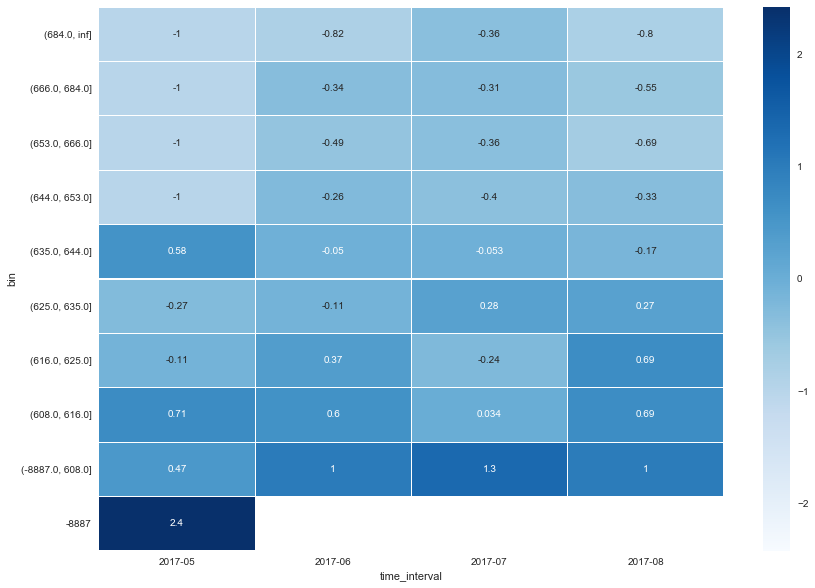

In [40]:
monthly_woe_pivot, f, plt = pl.check_badrate_trend(X_cat_train.loc[:, the_var], y_train, month, \
                                              RESULT_PATH, normalize=True)

# 检查变量按月分布的缺失率

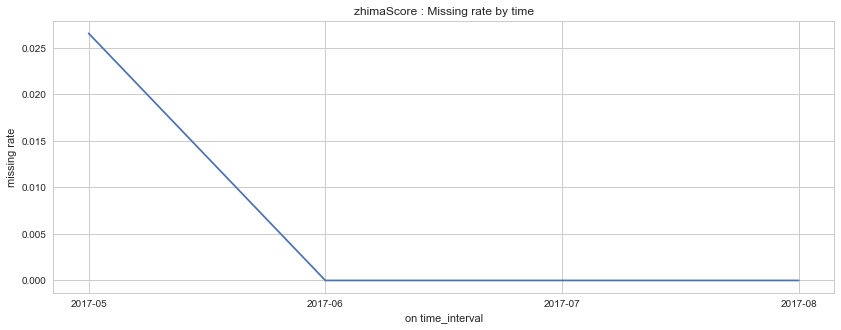

In [41]:
rates_by_month, f = pl.missing_trend(X_train.loc[:, the_var], month, RESULT_PATH)

# 模型评估

In [42]:
to_remove = set([u'V_AD_CN_MA_UL360D','phoneGrayScore','ipUsedNum','applyBalance','APP_RST','age'\
                ,'hd_firstCall2NowDays','hd_contactMobileNum','ivsScore','applyDays','hd_planAmtAvg'])

In [43]:
to_keep = list(set(selected)- to_remove)
to_keep

['province',
 'zhimaScore',
 'zx_creditLineAvg',
 'rm_ivsScore_v3',
 'tongdun6MIdSumLoanNumPf']

# 建模 & 评估

## 模型参数统计

In [44]:
# 统计训练集和测试集的划分比例
sample_split_summary = ss.sample_split_summary(y_train,y_test)

In [45]:
model_final, p_train, p_test = fs.FeatureSelection().logistic_regression(X_transformed_train[to_keep],\
                                                                           X_transformed_test[to_keep],\
                                                                           y_train)

In [46]:
# 训练集统计结果
train_stat = fs.FeatureSelection().model_stat_result(model_final,var_dict)
train_stat

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-2.018,0.066,942.706,0.000,-2.147,-1.889
province,申请省份,1.064,0.228,21.704,0.000,0.616,1.512
zhimaScore,芝麻分,0.762,0.110,48.369,0.000,0.547,0.977
zx_creditLineAvg,资信平均授信额度,0.741,0.245,9.135,0.003,0.260,1.221
rm_ivsScore_v3,IVS分,0.582,0.099,34.667,0.000,0.388,0.775
tongdun6MIdSumLoanNumPf,6个月内身份证在外部平台借款平台数,0.753,0.095,63.465,0.000,0.568,0.938


In [47]:
model_final_test, _, _ = fs.FeatureSelection().logistic_regression(X_transformed_test[to_keep],\
                                                                X_transformed_test[to_keep],\
                                                                y_test)

In [48]:
test_stat = fs.FeatureSelection().model_stat_result(model_final_test,var_dict)
test_stat

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-2.163,0.109,396.713,0.000,-2.376,-1.950
province,申请省份,0.349,0.401,0.758,0.384,-0.437,1.134
zhimaScore,芝麻分,1.025,0.184,31.166,0.000,0.665,1.384
zx_creditLineAvg,资信平均授信额度,0.158,0.333,0.225,0.635,-0.495,0.812
rm_ivsScore_v3,IVS分,0.718,0.157,20.872,0.000,0.410,1.027
tongdun6MIdSumLoanNumPf,6个月内身份证在外部平台借款平台数,0.665,0.147,20.542,0.000,0.377,0.952


## ks曲线

<module 'matplotlib.pyplot' from '/Users/ying.xie/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

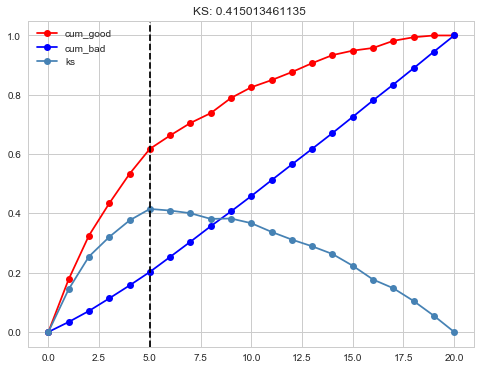

In [49]:
pl.ks_new(np.array(p_train), np.array(y_train), save_label='model_nozhima_train', \
          plot=True, result_path=RESULT_PATH)

<module 'matplotlib.pyplot' from '/Users/ying.xie/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

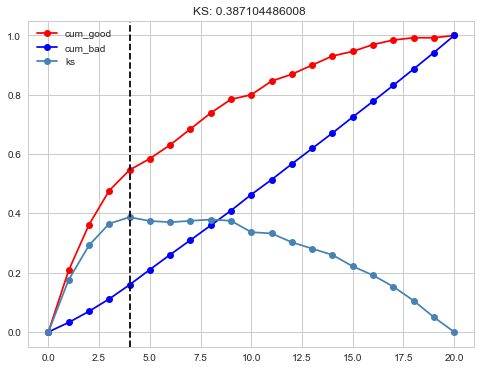

In [50]:
# Test KS
pl.ks_new(np.array(p_test), np.array(y_test), save_label='model_nozhima_test', \
          plot=True, result_path=RESULT_PATH)

(0.77005327172397997, <matplotlib.figure.Figure at 0x11534acf8>)

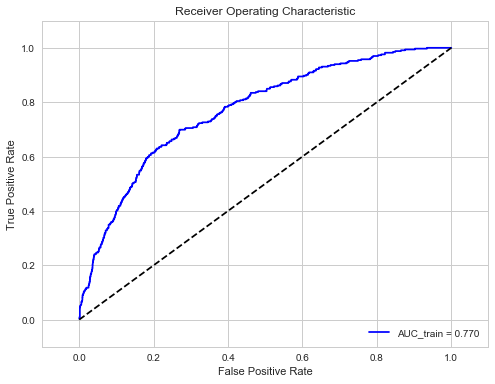

In [51]:
pl.print_AUC_one(y_train, p_train, save_label='model_nozhima_train', result_path=RESULT_PATH)

(0.76586977921530019, <matplotlib.figure.Figure at 0x115819160>)

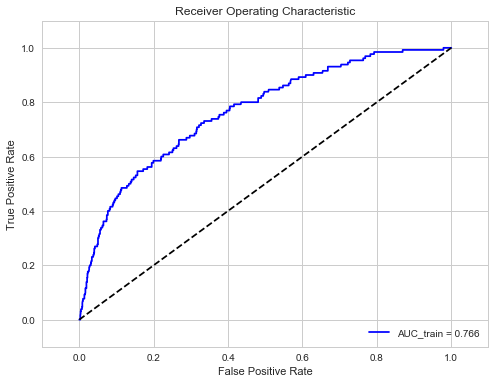

In [52]:
pl.print_AUC_one(y_test, p_test, save_label='model_nozhima_test', result_path=RESULT_PATH)

## 变量的相关系数

In [53]:
corr = X_transformed_train[to_keep].corr()

## 评分卡

In [54]:
coefficients = model_final.params.to_frame('beta').reset_index().rename(columns={'index':'var_code'})

In [56]:
cleaned_woe = woe_iv_df_coarse.loc[woe_iv_df_coarse[u'指标英文'].isin(coefficients.var_code), [u'指标英文', u'分箱', 'N', u'分布占比', 'WOE', u'逾期率', u'Bad分布占比']]
cleaned_woe.head()

,指标英文,分箱,N,分布占比,WOE,逾期率,Bad分布占比
47,province,1.0,232,0.081232,0.042405,0.120690,0.0843
48,province,2.0,222,0.077731,-0.177786,0.099099,0.0663
49,province,3.0,200,0.070028,-0.413730,0.080000,0.0482
50,province,4.0,535,0.187325,-0.117849,0.104673,0.1687
51,province,5.0,217,0.075980,0.510826,0.179724,0.1175


In [57]:
score_card = mt.Performance().calculate_score(coefficients, cleaned_woe, 'var_score', var_dict)

## 算分 & decile

In [65]:
selected = [i for i in coefficients.var_code if i != 'const']
train_score = mt.Performance().calculate_score_by_scrd(X_cat_train[selected], score_card)[1]
test_score = mt.Performance().calculate_score_by_scrd(X_cat_test[selected], score_card)[1]

province scoring started
rm_ivsScore_v3 scoring started
tongdun6MIdSumLoanNumPf scoring started
zhimaScore scoring started
zx_creditLineAvg scoring started
province scoring started
rm_ivsScore_v3 scoring started
tongdun6MIdSumLoanNumPf scoring started
zhimaScore scoring started
zx_creditLineAvg scoring started


In [66]:
type(train_score)

pandas.core.series.Series

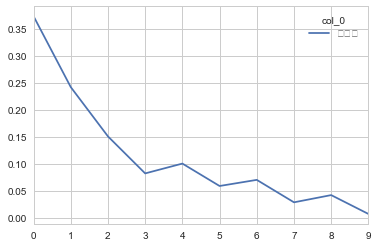

In [68]:
# 训练集
ks_decile_train = mt.Performance().calculate_ks_by_decile(train_score, np.array(y_train), 'decile', q=10)
ks_decile_train[[u'分箱',u'逾期率']].plot()

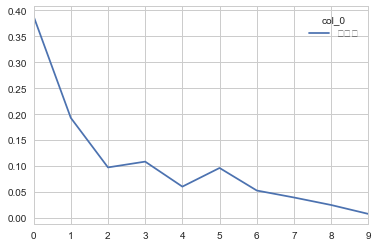

In [69]:
# 测试集
point_bounds = mt.BinWoe().obtain_boundaries(ks_decile_train[u'分箱'])['cut_boundaries']
ks_decile_test = mt.Performance().calculate_ks_by_decile(test_score, np.array(y_test), 'decile', \
                                                         manual_cut_bounds=point_bounds)
ks_decile_test[[u'分箱',u'逾期率']].plot()

## 生成runbook

In [70]:
run_book = mt.Performance().calculate_ks_by_decile(pd.concat([test_score,train_score],join='outer'), np.array(pd.concat([y_test,y_train],join='outer')), 'decile', \
                                                         q=20)

## 分数分布

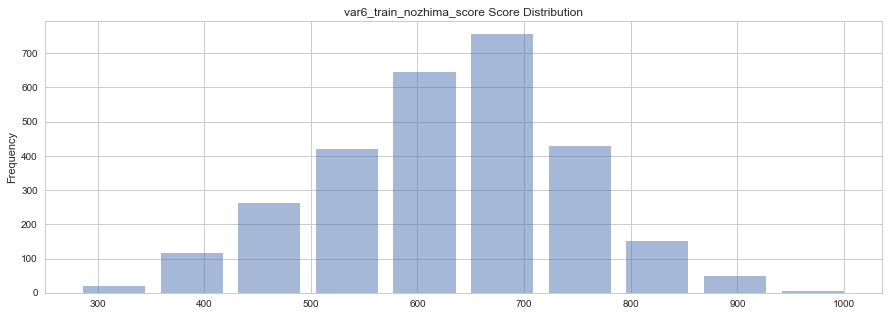

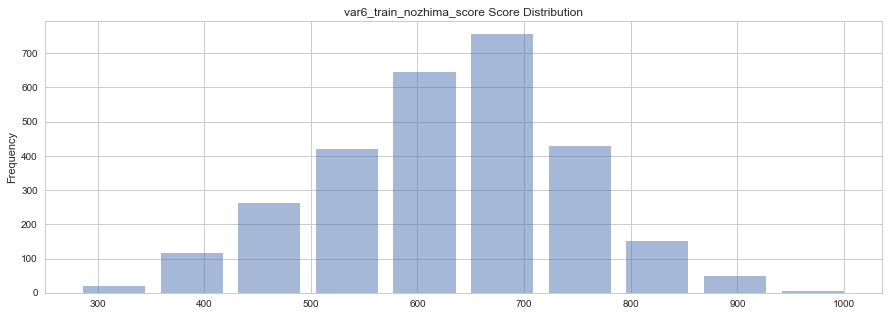

In [71]:
pl.score_dist_plot(train_score, 10, 'var6_train_nozhima_score', RESULT_PATH)

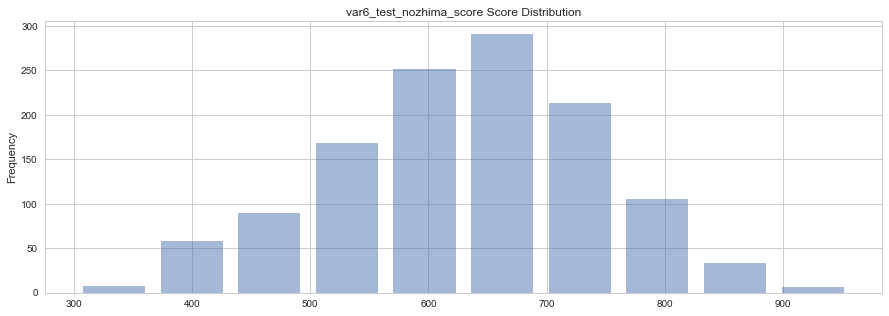

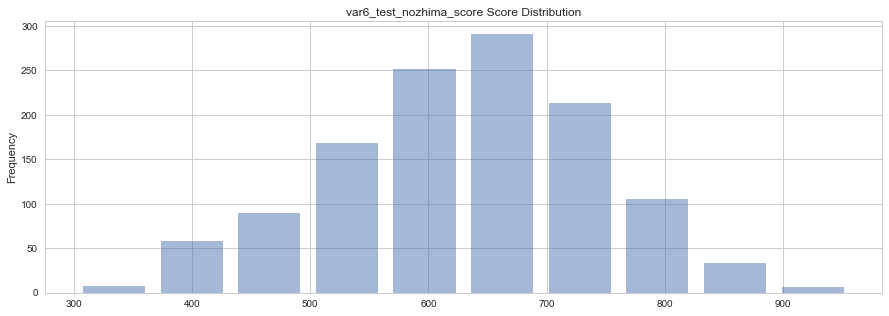

In [72]:
pl.score_dist_plot(test_score, 10, 'var6_test_nozhima_score', RESULT_PATH)

# 稳定性评估

## 每个变量的PSI

In [73]:
perf = mt.Performance()
selected = [i for i in coefficients.var_code if i != 'const']

In [74]:
var_psi_result = perf.variable_psi(X_cat_train[selected], X_cat_test[selected], var_dict)

variable PSI for province
variable PSI for zhimaScore
variable PSI for zx_creditLineAvg
variable PSI for rm_ivsScore_v3
variable PSI for tongdun6MIdSumLoanNumPf


<module 'matplotlib.pyplot' from '/Users/ying.xie/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

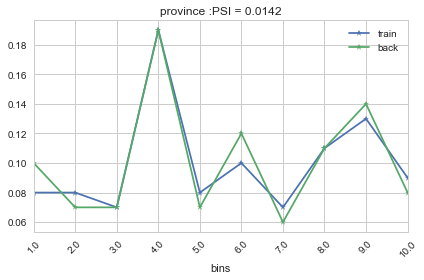

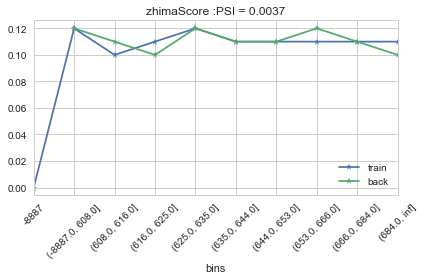

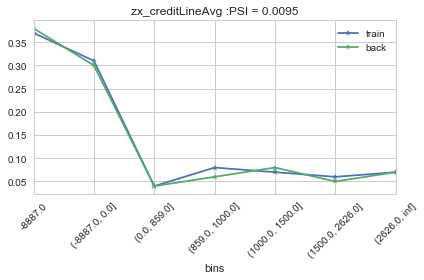

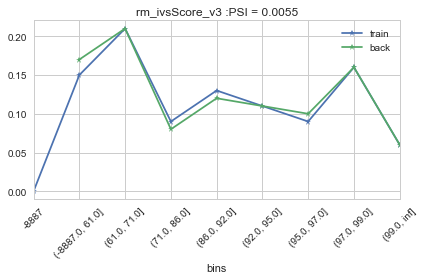

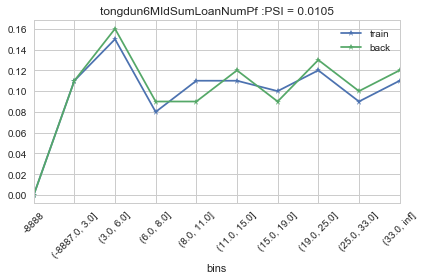

In [76]:
pl.variable_psi_plot(var_psi_result,'train','back','/Users/ying.xie/Desktop')

## 打分的PSI

In [77]:
all_score_to_plot,score_psi_result_good,score_psi_result_bad,bins = \
perf.all_score_psi_summary(train_score,test_score,10,y,'train','test')

score_good PSI: 0.0131
score_bad PSI: 0.0464


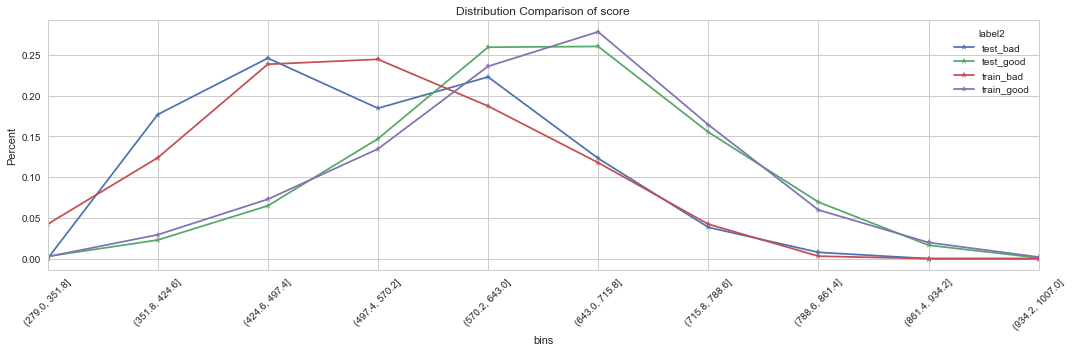

In [78]:
# 将两者的结果汇总
pl.compare_dist(all_score_to_plot, 'score', 'label2', \
              'train_test_by_good_bad', RESULT_PATH, \
              cut_bounds=bins)
print('score_good PSI: %.4f'%score_psi_result_good.PSI.mean())
print('score_bad PSI: %.4f'%score_psi_result_bad.PSI.mean())

# 拒绝样本打分

## 为拒绝样本填充缺失值，并转换数据格式

In [96]:
reject_data_4test = mu.process_missing(reject_data_4test, var_dict, known_missing={-9999999: -8887})
reject_data_4test = mu.convert_right_data_type(reject_data_4test, var_dict)[0]

Warnings: downflag variable is not in downflagmap provided for 芝麻IVS
Warnings: downflag variable is not in downflagmap provided for 算话
Warnings: downflag variable is not in downflagmap provided for 蜜罐
Warnings: downflag variable is not in downflagmap provided for 同盾线上
Warnings: downflag variable is not in downflagmap provided for 芝麻DAS
Warnings: downflag variable is not in downflagmap provided for 资信
Warnings: downflag variable is not in downflagmap provided for 未分组
Warnings: downflag variable is not in downflagmap provided for 申请信息
Warnings: downflag variable is not in downflagmap provided for 读秒个贷业务数据
Warnings: downflag variable is not in downflagmap provided for 话单
Warnings: downflag variable is not in downflagmap provided for 积木内部逾期
Warnings: downflag variable is not in downflagmap provided for 聚信力
Warnings: downflag variable is not in downflagmap provided for 本地黑名单详情
hd_percentOfLocalCall conversion failed
hd_percentOfLocalCall conversion failed. Type should be int, but is still o

## 为拒绝样本进行分箱以及WOE转换

In [97]:
bin_obj = mt.BinWoe()
selected = [i for i in coefficients.var_code if i != 'const']
reject_X_cat = bin_obj.convert_to_category(reject_data_4test[selected], var_dict, rebin_spec_bin_adjusted)
reject_X_transformed = bin_obj.transform_x_all(reject_X_cat, woe_iv_df_coarse)

province started checking 数据类型 before the conversion
province started the binning conversion
province有新的类别出现,替换 1 条数据值为-9999: ['青海省']
province finished the binning conversion
applyDays started checking 数据类型 before the conversion
zx_creditLineAvg started checking 数据类型 before the conversion
zx_creditLineAvg started the binning conversion
zx_creditLineAvg finished the binning conversion
tongdun6MIdSumLoanNumPf started checking 数据类型 before the conversion
tongdun6MIdSumLoanNumPf started the binning conversion
tongdun6MIdSumLoanNumPf finished the binning conversion
rm_ivsScore_v3 started checking 数据类型 before the conversion
rm_ivsScore_v3 started the binning conversion
rm_ivsScore_v3 finished the binning conversion
hd_firstCall2NowDays started checking 数据类型 before the conversion
phoneGrayScore started checking 数据类型 before the conversion
hd_contactMobileNum started checking 数据类型 before the conversion
age started checking 数据类型 before the conversion
zhimaScore started checking 数据类型 before the co

## 为拒绝样本打分

In [177]:
# 拒绝样本中有一些省份原来的分箱中没有
reject_X_cat = reject_X_cat[~(reject_X_cat.province=="青海省")]
reject_score = mt.Performance().calculate_score_by_scrd(reject_X_cat[selected], score_card)

KeyError: "['V_AD_CN_MA_UL360D' 'hd_callsAgencyContactAvgTimeL6M'\n 'rm_zx_ttl_drawdown_amt' 'rm_zx_osbal_count' 'sex' 'hd_longTimeSD7DayNum'\n 'rm_zx_dept_cnt_1m' 'zx_loanNum' 'tongdunIdMultiLoanNumPf'\n 'hd_tachCellphoneCount' 'hd_numberOfCallsWithBankIn3Months'\n 'hd_tripDaysIn6Months' 'rm_zx_sec_mthly_payment' 'hd_callsSource'\n 'hd_authMatchScore' 'applyDays' 'shCISLoanQueryNo_3month'\n 'hd_callsAgencyContactNumL6M' 'tongdunPhoneMultiLoanNum' 'zx_query_count'\n 'zx_dept_count' 'V_AD_CN_MA_UL180D' 'rm_zx_query_count_6M'\n 'hd_tripDaysFromTop1CityIn6Months' 'tongdun6MIdXiaofeiFenqiLoanNum'\n 'rm_zx_unsec_os_amt' 'rm_zx_unsec_mthly_payment' 'rm_zx_query_count_3M'\n 'hd_planAmtAvg' 'hd_firstCall2NowDays' 'ADDR_Mismatch' 'phoneGrayScore'\n 'hd_callEcpNumber' 'hd_p3NoCalledCount' 'channel' 'rm_zx_ttl_os_amt'\n 'mateNum' 'rm_zx_mthly_payment' 'hd_onlineDuration'\n 'hd_averageCallDuration' 'hd_contactMobileNum'\n 'hd_callsAgencyContactCalledAvgTimeL6M' 'age' 'zx_query_count2'\n 'tongdunIdMultiLoanNum' 'ADDR_Match_Recency_Good' 'hd_countOfLocalCallL6M'\n 'hd_averageCalls' 'ipUsedNum' 'hd_allCityIsEQ' 'currentJobyear' 'APP_RST'\n 'applyBalance' 'hd_countCallsOf110' 'monthIncome'\n 'hd_callsAgencyContactCalledNumL6M' 'rm_zx_max_drawdown_amt'\n 'tongdunPhoneMultiLoanNumPf' 'hd_maxOfflineDaysIn3Months'\n 'rm_zx_query_count_1M' 'hd_longTimeSDDaysMax'] not in index"

## 拒绝样本的打分分布于训练集中的好人打分和坏人打分做对比

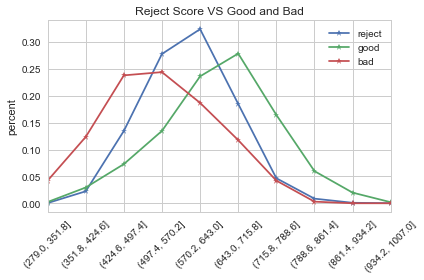

In [178]:
# 训练集中的好人
train_good_score = train_score.loc[y_train[y_train==0].index]
# 训练集中的坏人
train_bad_score = train_score.loc[y_train[y_train==1].index]
# # 打分分布
pl.reject_score_dis(reject_score[1],train_good_score,train_bad_score,RESULT_PATH)

# Back test／Out of sample／Indeterminate

## 将Out of sample样本进行缺失值填充以及数据转换

In [102]:
back_X = mu.process_missing(out_sample_data, var_dict, known_missing={-9999999: -8887})
back_X,_ = mu.convert_right_data_type(back_X, var_dict)

Warnings: downflag variable is not in downflagmap provided for 芝麻IVS
Warnings: downflag variable is not in downflagmap provided for 算话
Warnings: downflag variable is not in downflagmap provided for 蜜罐
Warnings: downflag variable is not in downflagmap provided for 同盾线上
Warnings: downflag variable is not in downflagmap provided for 芝麻DAS
Warnings: downflag variable is not in downflagmap provided for 资信
Warnings: downflag variable is not in downflagmap provided for 未分组
Warnings: downflag variable is not in downflagmap provided for 申请信息
Warnings: downflag variable is not in downflagmap provided for 读秒个贷业务数据
Warnings: downflag variable is not in downflagmap provided for 话单
Warnings: downflag variable is not in downflagmap provided for 积木内部逾期
Warnings: downflag variable is not in downflagmap provided for 聚信力
Warnings: downflag variable is not in downflagmap provided for 本地黑名单详情
Zhimaivs_DownFlag conversion failed
Zhimaivs_DownFlag conversion failed. Type should be int, but is still object
hd

In [103]:
# 依然有一些脏数据
back_X = back_X[~(back_X.province=='-9999')]

### 取出样本外数据的y

In [104]:
back_y = pd.Series(np.where(out_sample_data.his_max_overdue_days >30,1,0))
back_y = back_y[back_y.index.isin(back_X.index)]

## 进行分箱以及WOE转换

In [108]:
# 对样本外数据woe分箱
bin_obj = mt.BinWoe()
back_X_cat = bin_obj.convert_to_category(back_X[selected], var_dict, rebin_spec_bin_adjusted)
back_X_transformed = bin_obj.transform_x_all(back_X_cat, woe_iv_df_coarse)

province started checking 数据类型 before the conversion
province started the binning conversion
province finished the binning conversion
applyDays started checking 数据类型 before the conversion
zx_creditLineAvg started checking 数据类型 before the conversion
zx_creditLineAvg started the binning conversion
zx_creditLineAvg finished the binning conversion
tongdun6MIdSumLoanNumPf started checking 数据类型 before the conversion
tongdun6MIdSumLoanNumPf started the binning conversion
tongdun6MIdSumLoanNumPf finished the binning conversion
rm_ivsScore_v3 started checking 数据类型 before the conversion
rm_ivsScore_v3 started the binning conversion
rm_ivsScore_v3 finished the binning conversion
hd_firstCall2NowDays started checking 数据类型 before the conversion
phoneGrayScore started checking 数据类型 before the conversion
hd_contactMobileNum started checking 数据类型 before the conversion
age started checking 数据类型 before the conversion
zhimaScore started checking 数据类型 before the conversion
zhimaScore started the binning c

## 对样本进行打分

In [118]:
back_X_transformed.head(5)

,province,zhimaScore,zx_creditLineAvg,rm_ivsScore_v3,tongdun6MIdSumLoanNumPf
0,-0.288939,0.875627,-0.0161936,-0.868413,-0.097616
1,-0.117849,-0.778851,-0.119011,0.62253,0.124298
2,0.345191,0.451321,0.190025,-0.161533,-0.599652
3,-0.0892564,-0.0624612,0.190025,0.62253,0.309778
4,-0.288939,-0.0624612,0.190025,0.0190482,0.309778


In [132]:
selected = [i for i in coefficients.var_code if i != 'const']
back_score = mt.Performance().calculate_score_by_scrd(back_X_transformed[selected], score_card)[1]

province scoring started
rm_ivsScore_v3 scoring started
tongdun6MIdSumLoanNumPf scoring started
zhimaScore scoring started
zx_creditLineAvg scoring started


## 单变量稳定性分析

In [125]:
perf2 = mt.Performance()
var_psi_result_back = perf2.variable_psi(X_cat_train[selected], back_X_cat[selected], var_dict)

variable PSI for province
variable PSI for zhimaScore
variable PSI for zx_creditLineAvg
variable PSI for rm_ivsScore_v3
variable PSI for tongdun6MIdSumLoanNumPf


<module 'matplotlib.pyplot' from '/Users/ying.xie/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

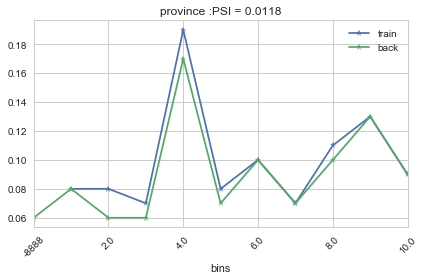

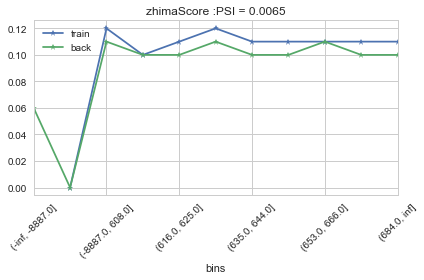

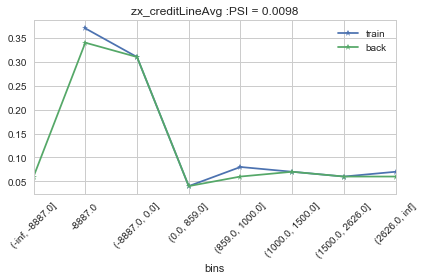

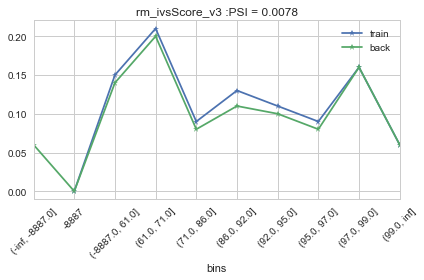

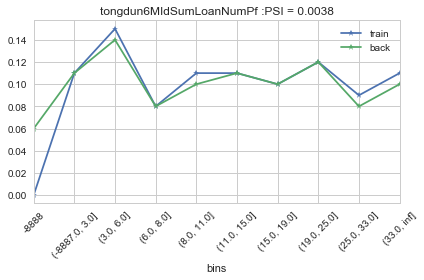

In [126]:
pl.variable_psi_plot(var_psi_result_back,'train','back',RESULT_PATH)

## 打分分布PSI

### 合并训练集的y和样本外数据的y

In [127]:
y_with_back = pd.concat([y_train,back_y])

In [134]:
all_score_to_plot2,score_psi_result_good2,score_psi_result_bad2,bins2\
= perf2.all_score_psi_summary(train_score,back_score,8,y_with_back,'train','back')

score_good PSI: 0.9558
score_bad PSI: 1.1810


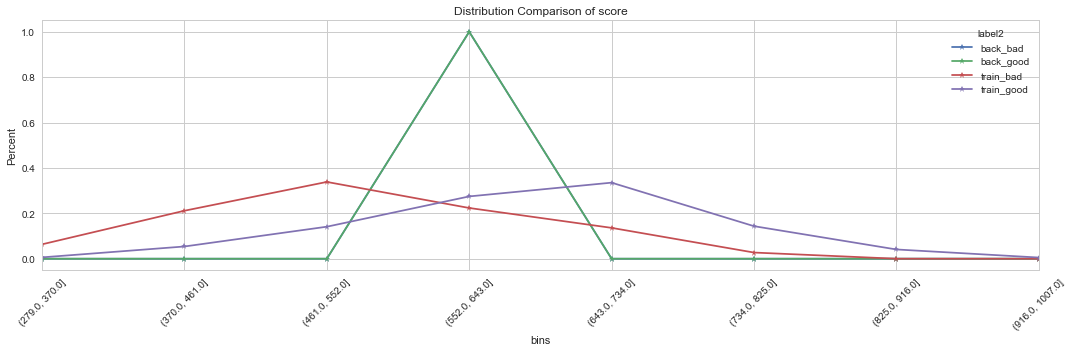

In [135]:
pl.compare_dist(all_score_to_plot2, 'score', 'label2', \
              'train_back_by_good_bad', RESULT_PATH, \
              cut_bounds=bins2)
print('score_good PSI: %.4f'%score_psi_result_good2.PSI.mean())
print('score_bad PSI: %.4f'%score_psi_result_bad2.PSI.mean())

# 近一个月样本打分

## 将近一个月数据填充缺失值并进行数据转换

In [179]:
recent_1m_data_X = mu.process_missing(recent_1m_data, var_dict, known_missing={-9999999: -8887})
recent_1m_data_X = mu.convert_right_data_type(recent_1m_data_X, var_dict)[0]

Warnings: downflag variable is not in downflagmap provided for 芝麻IVS
Warnings: downflag variable is not in downflagmap provided for 算话
Warnings: downflag variable is not in downflagmap provided for 蜜罐
Warnings: downflag variable is not in downflagmap provided for 同盾线上
Warnings: downflag variable is not in downflagmap provided for 芝麻DAS
Warnings: downflag variable is not in downflagmap provided for 资信
Warnings: downflag variable is not in downflagmap provided for 未分组
Warnings: downflag variable is not in downflagmap provided for 申请信息
Warnings: downflag variable is not in downflagmap provided for 读秒个贷业务数据
Warnings: downflag variable is not in downflagmap provided for 话单
Warnings: downflag variable is not in downflagmap provided for 积木内部逾期
Warnings: downflag variable is not in downflagmap provided for 聚信力
Warnings: downflag variable is not in downflagmap provided for 本地黑名单详情
hd_percentOfLocalCall conversion failed
hd_percentOfLocalCall conversion failed. Type should be int, but is still o

## 将近一个月数据进行分箱并转换WOE

In [143]:
# 对样本外数据woe分箱
bin_obj = mt.BinWoe()
selected = [i for i in coefficients.var_code if i != 'const']
recent_1m_data_X_cat = bin_obj.convert_to_category(recent_1m_data_X[selected], var_dict, rebin_spec_bin_adjusted)
recent_1m_data_X_transformed = bin_obj.transform_x_all(recent_1m_data_X_cat, woe_iv_df_coarse)

province started checking 数据类型 before the conversion
province started the binning conversion
province finished the binning conversion
applyDays started checking 数据类型 before the conversion
zx_creditLineAvg started checking 数据类型 before the conversion
zx_creditLineAvg started the binning conversion
zx_creditLineAvg finished the binning conversion
tongdun6MIdSumLoanNumPf started checking 数据类型 before the conversion
tongdun6MIdSumLoanNumPf started the binning conversion
tongdun6MIdSumLoanNumPf finished the binning conversion
rm_ivsScore_v3 started checking 数据类型 before the conversion
rm_ivsScore_v3 started the binning conversion
rm_ivsScore_v3 finished the binning conversion
hd_firstCall2NowDays started checking 数据类型 before the conversion
phoneGrayScore started checking 数据类型 before the conversion
hd_contactMobileNum started checking 数据类型 before the conversion
age started checking 数据类型 before the conversion
zhimaScore started checking 数据类型 before the conversion
zhimaScore started the binning c

In [153]:
recent_1m_score = mt.Performance().calculate_score_by_scrd(recent_1m_data_X_cat[selected], score_card)[1]

province scoring started
rm_ivsScore_v3 scoring started
tongdun6MIdSumLoanNumPf scoring started
zhimaScore scoring started
zx_creditLineAvg scoring started


## 单变量PSI

In [145]:
perf3 = mt.Performance()
var_psi_result_1m = perf3.variable_psi(X_cat_train[selected], recent_1m_data_X_cat[selected], var_dict)

variable PSI for province
variable PSI for zhimaScore
variable PSI for zx_creditLineAvg
variable PSI for rm_ivsScore_v3
variable PSI for tongdun6MIdSumLoanNumPf


<module 'matplotlib.pyplot' from '/Users/ying.xie/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

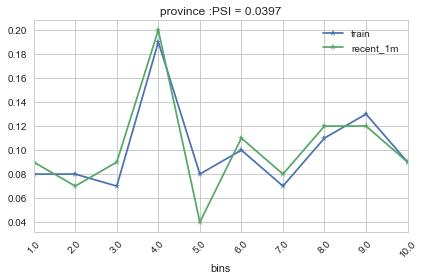

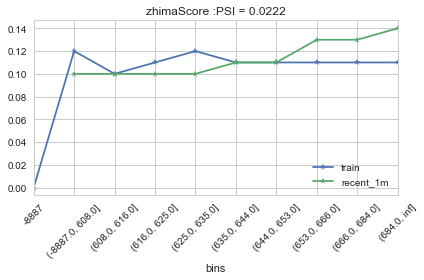

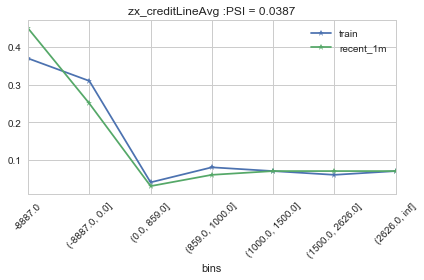

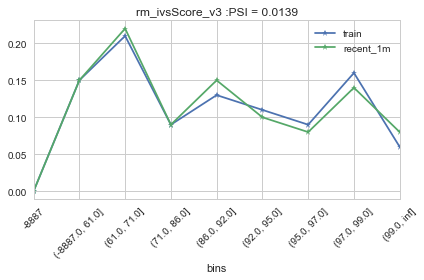

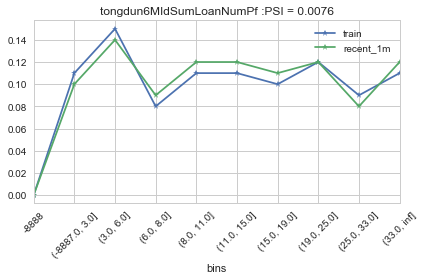

In [146]:
pl.variable_psi_plot(var_psi_result_1m,'train','recent_1m',RESULT_PATH)

## 打分PSI

In [154]:
score_psi_result_1m = perf.score_psi(train_good_score, recent_1m_score, score_cut_bins=bins)

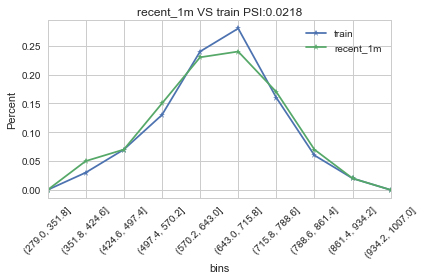

In [155]:
pl.plot_score_compare(score_psi_result_1m,'train','recent_1m',RESULT_PATH)

# 变量进入过程

In [157]:
n=70
top_n = ranking_result.sort_values('overall_rank')[u'指标英文'].iloc[:n].tolist()
exclusion = ['address','idcardAreaNumber','hd_applyCity','city'\
             ,'hd_operatorCity','hd_topOneCity','rm_watchlistRiskCode','zmc_ivsFraudHit','ivsScore','rm_ivsScore_v3','applyHour','zhimaScore']
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

In [158]:
selection_process = summary.loc[:, [u'指标英文', u'指标中文','exclusion_reason']]

selection_process.loc[:, 'kept_after_EDA'] = np.where(selection_process.exclusion_reason.notnull(), 0, 1)
selection_process.loc[:, 'kept_after_ranking'] = np.where(selection_process[u'指标英文'].isin(selected), 1, 0)

kept2 = list(model_result.loc[model_result.FORWARD_AIC_rank.notnull(), u'指标英文'].unique()) + ['zhimaScore', 'tongdun6MIdSumLoanNumPf', 'shop_type']
selection_process.loc[:, 'kept_after_stepwise_and_correlation'] = np.where(selection_process[u'指标英文'].isin(kept2), 1, 0)

final_selected = [i for i in coefficients.var_code if i != 'const']

selection_process.loc[:, 'final_selected'] = np.where(selection_process[u'指标英文'].isin(final_selected), 1, 0)

In [159]:
selection_process.rename(columns = {'exclusion_reason': 'EDA后去掉的原因',\
                                    'kept_after_EDA': 'EDA后保留',\
                                    'kept_after_ranking': '综合排序后保留',\
                                    'kept_after_stepwise_and_correlation': 'Stepwise和共线性处理后保留',\
                                    'final_selected': '最终模型保留'
                                   }, inplace=True)

# 生成最终报告

In [160]:
FIG_PATH = u'/Users/ying.xie/Documents/yings_file/seafile/分析文件/modeling/个贷/XJD_WK_A_V1/04_result/figure'
RESULT_PATH_2 = u'/Users/ying.xie/Desktop/'
# 评分分布的图片，list中的顺序必须是训练集的图片名，然后才是测试集的图片名称
score_dis = [u'score_dist/var6_train_nozhima_score_dist_plot.png',\
             u'score_dist/var6_test_nozhima_score_dist_plot.png']
# KS和AUC的图片，list中的顺序必须是训练集测试集KS图片，然后才是训练集测试集AUC的图片名称，存储顺序不可改变
ks_auc = [u'KS/model_nozhima_train_KS.png',u'KS/model_nozhima_test_KS.png'\
                      ,u'AUC/model_nozhima_train_AUC.png',u'AUC/model_nozhima_test_AUC.png']
#打分分布图的图片路径，切记顺序不能变
score_PSI = ['compare_dist/recent_1m VS train PSI.png',\
              'compare_dist/train_back_by_good_bad_compare_dist.png',\
              'compare_dist/train_test_by_good_bad_compare_dist.png']

<font size=4 color=red> 1、***切记保留all_data_dic_c的keys的顺序，即保留13个key，但key的名称可以修改!*** </font>

<font size=4> 2、***不存在的数据直接写None，也就不会生成sheet*** </font><font size=4 color=red> ***，不要写成[None],会报错!*** </font>

<font size=4 color=red> 3、***现阶段只支持有训练集和测试集版本的，无测试集的后续开发中*** </font>

In [161]:
# 采用OrderedDict保证生成的all_data_dict中生成的keys的顺序不会改变
import collections
all_data_dic_c = collections.OrderedDict()

all_data_dic_c[u'附2变量字典'] = var_dict
all_data_dic_c[u'附1变量进入过程'] = selection_process

# var_psi_result_1m,score_psi_result_1m两者者顺序不能变
#all_data_dic_c[u'S3.11近一个月数据PSI统计'] = [var_psi_result_1m,score_psi_result_1m]
all_data_dic_c[u'S3.11近一个月数据PSI统计'] = None

# var_psi_result_back,score_psi_result_good2,score_psi_result_bad2三者顺序不能变
#all_data_dic_c[u'S3.10样本外测试PSI统计'] = [var_psi_result_back,score_psi_result_good2,score_psi_result_bad2]
all_data_dic_c[u'S3.10样本外测试PSI统计'] = None

# 这个相对特殊，value是图片路径路径
#all_data_dic_c[u'S3.9拒绝样本打分分布'] = 'compare_dist/reject_score_dis.png'
all_data_dic_c[u'S3.9拒绝样本打分分布'] = None

# var_psi_result,score_psi_result_good,score_psi_result_bad三者顺序不能变
#all_data_dic_c[u'S3.8训练集测试集PSI统计'] = [var_psi_result,score_psi_result_good,score_psi_result_bad]
all_data_dic_c[u'S3.8训练集测试集PSI统计'] = None

# ks_decile_train,ks_decile_test,run_book三者顺序不能变
all_data_dic_c[u'S3.7决策参考'] = [ks_decile_train,ks_decile_test,run_book]

all_data_dic_c[u'S3.6评分卡'] = score_card

# sample_split_summary,train_stat,test_stat,corr四者顺序不能变
all_data_dic_c[u'S3.5模型结果'] = [sample_split_summary,train_stat\
                               ,test_stat,corr]

all_data_dic_c[u'S3.4变量粗分箱'] = woe_iv_df_coarse
all_data_dic_c[u'S3.3变量细分箱'] = model_result
all_data_dic_c[u'S3.2变量重要性排序'] = ranking_result
all_data_dic_c[u'S3.1变量描述性统计'] = summary

In [162]:
ss.XlModelSummary(RESULT_PATH_2,FIG_PATH,u'test.xlsx',all_data_dic_c,score_dis,ks_auc,score_PSI).run()

# 模型部署

In [164]:
model_selected = score_card[u'指标英文'].unique()
model_selected

array(['province', 'rm_ivsScore_v3', 'tongdun6MIdSumLoanNumPf',
       'zhimaScore', 'zx_creditLineAvg', 'intercept'], dtype=object)

In [165]:
rebin_spec_json = mu.process_rebin_spec(rebin_spec_bin_adjusted, var_dict, model_selected)

In [167]:
bin_to_score_json = mu.process_bin_to_score(score_card.rename(columns={u'指标英文': u'中间层指标名称'}))

In [168]:
save_data_to_json(rebin_spec_json, RESULT_PATH_2, '%s_selected_rebin_spec.json' % 'test')

In [169]:
save_data_to_json(bin_to_score_json, RESULT_PATH_2, '%s_bin_to_score.json' % 'test')